# Source code for the paper "scqubits: a Python package for superconducting qubits" by Peter Groszkowski and Jens Koch

This notebook shows the source code presented in the manuscript of the paper "scqubits: a Python package for superconducting qubits". 
Note that in some sections, extra code that may be required to generate certain plots, which may not be explicitly shown in the paper, is also included here. 

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
import numpy as np
import scqubits as scq

make font larger to make plots for paper

In [2]:
params = {'legend.fontsize': 12,
         'axes.labelsize': 12,
         'axes.titlesize':12,
         'xtick.labelsize':12,
         'ytick.labelsize':12}
plt.rcParams.update(params)


# Overview of the scqubits library

In [3]:
scq.GUI()

Output(layout=Layout(width='975px'))

In [4]:
tmon = scq.TunableTransmon(
    EJmax=15.0, 
    EC=0.6,
    d=0.02,
    flux=0.0,
    ng=0.03,
    ncut=32
)



In [5]:
tmon.eigenvals(evals_count=12)

array([-10.91336985,  -3.07982721,   3.97114311,  10.41412203,
        14.06408929,  22.60137815,  23.43176307,  38.59265942,
        39.72096178,  59.76406786,  61.19239859,  85.87012806])

Text(-0.15, 0.97, '(a)')

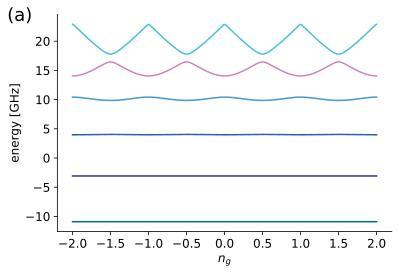

In [6]:
ng_list = np.linspace(-2, 2, 220)
fig, ax=tmon.plot_evals_vs_paramvals('ng', ng_list,
                             evals_count=6)

ax.text(-0.15, 0.97, "(a)", transform=ax.transAxes, size=18)
# fig.savefig("../graphics/energies.pdf")


In [7]:
evals, evecs = tmon.eigensys()

Text(-0.15, 0.97, '(b)')

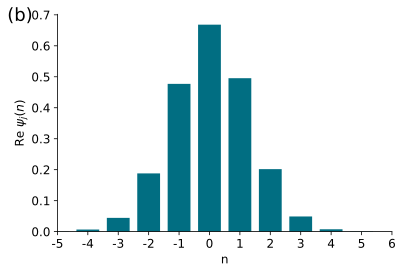

In [8]:
fig, ax=tmon.plot_n_wavefunction(which=0, mode='real');
ax.text(-0.15, 0.97, "(b)", transform=ax.transAxes, size=18)
# fig.savefig("../graphics/wavefunctionChargeBasis.pdf")

Text(-0.15, 0.97, '(c)')

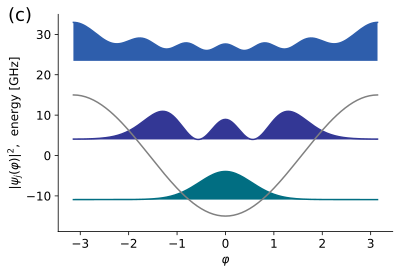

In [9]:
fig, ax=tmon.plot_phi_wavefunction(which=[0,2,6],
                           mode='abs_sqr');
ax.text(-0.15, 0.97, "(c)", transform=ax.transAxes, size=18)
# fig.savefig("../graphics/wavefunctionPhaseBasis.pdf")

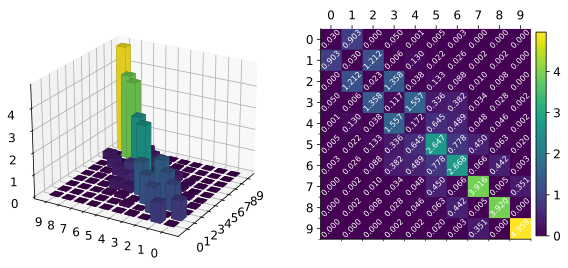

In [10]:
fig, ax=tmon.plot_matrixelements('n_operator',
                         evals_count=10, show_numbers=True)

# fig.savefig("../graphics/matrixElements.pdf")

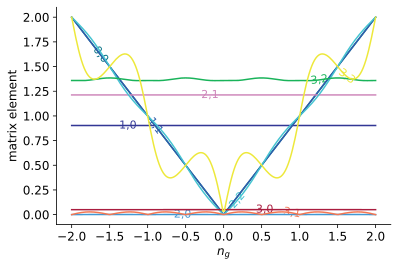

In [11]:
ng_list = np.linspace(-2, 2, 220)
fig, ax=tmon.plot_matelem_vs_paramvals('n_operator',
                               'ng', ng_list,
                               select_elems=4)
# fig.savefig("../graphics/selectMatrixElements.pdf")

In [12]:
#scq.get_units()
#scq.set_units('MHz')


# Composite Hilbert spaces and interface with Qutip

In [13]:
tmon1 = scq.Transmon(
    EJ=40.0,
    EC=0.2,
    ng=0.3,
    ncut=40,
    truncated_dim=4   
)

tmon2 = scq.Transmon(
    EJ=15.0,
    EC=0.15,
    ng=0.0,
    ncut=30,
    truncated_dim=4
)

resonator = scq.Oscillator(
    E_osc=4.5,
    truncated_dim=4 
)

In [14]:
hs = scq.HilbertSpace([tmon1,tmon2,resonator])


In [15]:
# coupling resonator-tmon1
g1 = 0.1  
operator1 = tmon1.n_operator()
operator2 = resonator.creation_operator() + resonator.annihilation_operator()

hs.add_interaction(
    g=g1,
    op1=(operator1, tmon1),  # (matrix, subsys)
    op2=(operator2, resonator)
)

# coupling resonator-tmon2
g2 = 0.2  
hs.add_interaction(
    g=g2,
    op1=tmon2.n_operator,    # class method
    op2=resonator.creation_operator,
    add_hc=True
)


In [16]:
hs = scq.HilbertSpace([tmon1, tmon2, resonator])
g3 = 0.1

hs.add_interaction(
    expr="g3 * cos(n) * adag",
    op1=("n", tmon1.n_operator(), tmon1),
    op2=("adag", resonator.creation_operator),
    add_hc=True
)


In [17]:
import qutip as qt
# Generate a Qobj
g = 0.1
a = qt.destroy(4)
kerr = a.dag() * a.dag() * a * a
id = qt.qeye(4)
V = g * qt.tensor(id, id, kerr)

hs.add_interaction(qobj=V)


In [18]:
dressed_hamiltonian = hs.hamiltonian()


In [19]:
evals = hs.eigenvals()  # or
evals, evecs = hs.eigensys()


# Sweeping over external parameters

In [20]:
# combine parameter names and values 
# in a dictionary
paramvals_by_name = {
    "flux": np.linspace(0.0, 2.0, 171), 
    "ng": np.linspace(-0.5, 0.5, 49)
}

area_ratio = 1.2
def update_hilbertspace(flux, ng):  
    # function that defines how Hilbert space 
    # components are updated
    tmon1.flux = flux
    tmon2.flux = area_ratio * flux
    tmon2.ng = ng

# dictionary specifying which subsystems are 
# affected by changing each parameters   
subsys_update_info = {"flux": [tmon1, tmon2],
                      "ng": [tmon2]}

# create the ParameterSweep object
sweep = scq.ParameterSweep(
    hilbertspace=hs,
    paramvals_by_name=paramvals_by_name,
    update_hilbertspace=update_hilbertspace,
    evals_count=20,
    subsys_update_info=subsys_update_info,
    num_cpus=4
)


Parallel compute bare eigensys [num_cpus=4]

Parallel compute bare eigensys [num_cpus=4]

Parallel compute bare eigensys [num_cpus=4]

Parallel compute dressed eigensys [num_cpus=4]

this code is to setup the plot_transitions() call - parts may not be explicitly shown in the paper

In [21]:
# Define HilbertSpace object:  two transmons coupled to an oscillator

tmon1 = scq.TunableTransmon(
    EJmax=40.0,
    EC=0.2,
    d=0.1,
    flux=0.0,
    ng=0.3,
    ncut=40,
    truncated_dim=3     # after diagonalization, we will keep 3 levels
)

tmon2 = scq.TunableTransmon(
    EJmax=15.0,
    EC=0.15,
    d=0.2,
    flux=0.0,
    ng=0.0,
    ncut=30,
    truncated_dim=3
)

resonator = scq.Oscillator(
    E_osc=4.5,
    truncated_dim=4    # up to 3 photons (0,1,2,3)
)

hilbertspace = scq.HilbertSpace([tmon1, tmon2, resonator])


g1 = 0.1  # coupling resonator-CPB1 (without charge matrix elements)
g2 = 0.2  # coupling resonator-CPB2 (without charge matrix elements)

hilbertspace.add_interaction(
    g_strength = g1,
    op1 = tmon1.n_operator,
    op2 = resonator.creation_operator,
    add_hc = True
)

hilbertspace.add_interaction(
    g_strength = g2,
    op1 = tmon2.n_operator,
    op2 = resonator.creation_operator,
    add_hc = True
)

In [22]:
# Set up parameter name and values
pname1 = 'flux'  
flux_vals = np.linspace(0.0, 2.0, 171)
pname2 = 'ng'
ng_vals = np.linspace(-0.5, 0.5, 49)

# combine into a dictionary
paramvals_by_name = {pname1: flux_vals, pname2: ng_vals}


area_ratio = 1.2

def update_hilbertspace(flux, ng):  # function that defines how Hilbert space components are updated
    tmon1.flux = flux
    tmon2.flux = area_ratio * flux
    tmon2.ng = ng

# dictionary with information on which subsystems are affected by changing parameters    
subsys_update_info = {pname1: [tmon1, tmon2],
                      pname2: [tmon2]}

    
# create the ParameterSweep    
sweep = scq.ParameterSweep(
    hilbertspace=hilbertspace,
    paramvals_by_name=paramvals_by_name,
    update_hilbertspace=update_hilbertspace,
    evals_count=20,
    subsys_update_info=subsys_update_info,
    num_cpus=4
)

Parallel compute bare eigensys [num_cpus=4]

Parallel compute bare eigensys [num_cpus=4]

Parallel compute bare eigensys [num_cpus=4]

Parallel compute dressed eigensys [num_cpus=4]

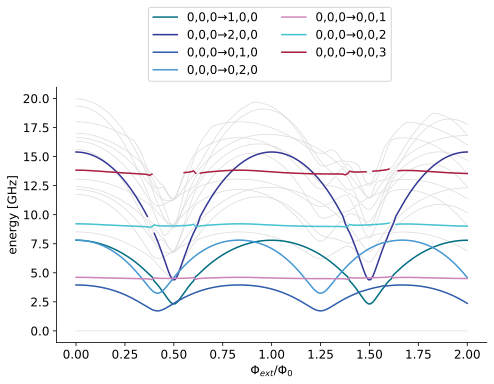

In [23]:
# fig, ax=plt.subplots(figsize=(7, 5.5), constrained_layout=True)
fig, ax=plt.subplots(figsize=(7, 5.5))
fig, ax=sweep["ng":0.0].plot_transitions(fig_ax=(fig, ax));
ax.legend(bbox_to_anchor=(0.20, 1.0), ncol=2)
fig.tight_layout()
fig.savefig("../graphics/transitionsPlot.pdf")


# Estimation of coherence times

In [24]:
# transmon = scq.Transmon(
#     EJ=0.5,
#     EC=12.0,
#     ng=0.3,
#     ncut=150
# )

In [25]:
tmon.supported_noise_channels()

['tphi_1_over_f_flux',
 'tphi_1_over_f_cc',
 'tphi_1_over_f_ng',
 't1_capacitive',
 't1_flux_bias_line',
 't1_charge_impedance']

In [26]:
# tmon.tphi_1_over_f_flux()
tmon.t1_capacitive()

See documentation for details.
This warning can be disabled by executing:
scqubits.settings.T1_DEFAULT_WARNING=False

 /home/pgroszko/Dropbox/1_research/libs/scqubits/scqubits/core/noise.py: 1174

16881.51355602749

In [27]:
tmon.t1_charge_impedance(i=3, j=1, 
                         Z=50, 
                         T=0.100, 
                         get_rate=False, 
                         total=False)

3606.7449426668377

In [28]:
tmon.t1_effective()


16881.51355602749

In [29]:
tmon.t1_effective(
    noise_channels=['t1_charge_impedance',
                    't1_flux_bias_line'],
    common_noise_options=dict(T=0.050)
)


0.25580751799518137

In [30]:
tmon.t2_effective(
    noise_channels=['t1_flux_bias_line',
                    't1_capacitive',
                    ('tphi_1_over_f_flux',   
                     dict(A_noise=3e-6))],
    common_noise_options=dict(T=0.050)
)


33726.40283983535

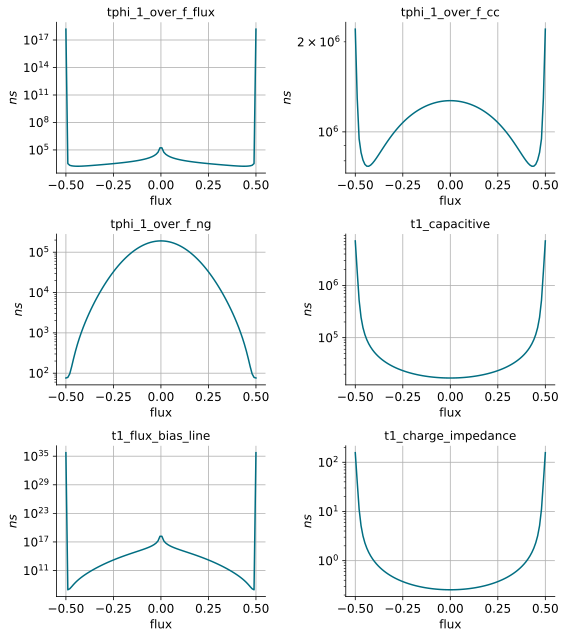

In [31]:
tmon.plot_coherence_vs_paramvals(
    param_name='flux', 
    param_vals=np.linspace(-0.5, 0.5, 100));


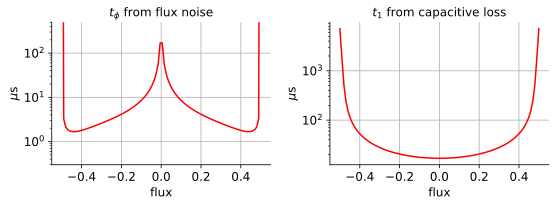

In [32]:
fig, ax = tmon.plot_coherence_vs_paramvals(
    param_name='flux',
    param_vals=np.linspace(-0.5, 0.5, 100),
    noise_channels=['tphi_1_over_f_flux',     
                    't1_capacitive'],
    scale=1e-3,
    color='red',
    ylabel=r"$\mu$s"
)
ax[0].set_title(r"$t_{\phi}$ from flux noise"); 
ax[0].set_ylim(None, 5e2)
ax[1].set_title(r"$t_1$ from capacitive loss"); 


# Interactive Exploration

In [33]:
fluxonium = scq.Fluxonium(
    EJ=2.55,
    EC=0.72,
    EL=0.12,
    flux=0.0,
    cutoff=110,
    truncated_dim=9
)

osc = scq.Oscillator(E_osc=4.0, truncated_dim=5)

In [34]:
hilbertspace = scq.HilbertSpace([fluxonium, osc])

In [35]:
hilbertspace.add_interaction(
    g_strength=0.2,
    op1=fluxonium.n_operator,
    op2=osc.creation_operator,
    add_hc=True
)

In [36]:
param_name = r'$\Phi_{ext}/\Phi_0$'
param_vals = np.linspace(-0.5, 0.5, 101)

subsys_update_list = [fluxonium]


def update_hilbertspace(param_val):
    fluxonium.flux = param_val


sweep = scq.ParameterSweep(
    paramvals_by_name={param_name: param_vals},
    evals_count=10,
    hilbertspace=hilbertspace,
    subsys_update_info={param_name: [fluxonium]},
    update_hilbertspace=update_hilbertspace,
)


Bare spectra:   0%|          | 0/101 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/1 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/101 [00:00<?, ?it/s]

In [37]:
explorer = scq.Explorer(
	sweep=sweep,
	evals_count=10
)
explorer.interact()

Output()

# A.I Harmonic and Kerr oscillators

In [38]:
osc=scq.Oscillator(E_osc=5)


In [39]:
kerr=scq.KerrOscillator(E_osc=5, K=0.1, 
                        l_osc=0.1)


# A.II Transmon qubit

In [40]:
transmon = scq.Transmon(EJ=30.02, EC=0.2, 
                        ng=0.0, ncut=101)

# A.III Fluxonium qubit

In [41]:
fluxonium = scq.Fluxonium(EJ=5.7, EC=1.2, 
                          EL=1.0, cutoff = 150, 
                          flux = 0.5,
                          truncated_dim=10)


# A.IV Flux qubit

In [42]:
EJ = 35.0
alpha = 0.6
fluxqubit = scq.FluxQubit(
    EJ1 = EJ,
    EJ2 = EJ,
    EJ3 = alpha*EJ,
    ECJ1 = 1.0,
    ECJ2 = 1.0,
    ECJ3 = 1.0/alpha,
    ECg1 = 50.0,
    ECg2 = 50.0,
    ng1 = 0.0,
    ng2 = 0.0,
    flux = 0.5,
    ncut = 10
)

# A.V $0-\pi$ qubit

In [43]:
phi_grid = scq.Grid1d(-8*np.pi, 8*np.pi, 200)
zeropi_dis = scq.ZeroPi(
    grid = phi_grid,
    EJ   = 10.0,
    dEJ = 0.05,
    EL   = 0.04,
    ECJ  = 20.0,
    dCJ = 0.05,
    EC = 0.04,
    ng   = 0.3,
    flux = 0.2,
    ncut = 30
)


# A.VI $\cos 2\phi $ qubit

In [44]:
cos2phi_qubit = scq.Cos2PhiQubit(
    EJ = 15.0,
    ECJ = 2.0,
    EL = 1.0,
    EC = 0.04,
    dCJ = 0.0,
    dL = 0.6,
    dEJ = 0.0,
    flux = 0.5,
    ng = 0.0,
    ncut = 7,
    phi_cut = 7,
    zeta_cut = 30
)
